# Product Placement
### Import packages and read the source csv in 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('./../data/product_positioning_raw.csv')


### Begin the EDA Process

In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product ID             1000 non-null   int64  
 1   Product Position       1000 non-null   object 
 2   Price                  1000 non-null   float64
 3   Competitor's Price     1000 non-null   float64
 4   Promotion              1000 non-null   object 
 5   Foot Traffic           1000 non-null   object 
 6   Consumer Demographics  1000 non-null   object 
 7   Product Category       1000 non-null   object 
 8   Seasonal               1000 non-null   object 
 9   Sales Volume           1000 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 78.3+ KB
None
          Product ID        Price  Competitor's Price  Sales Volume
count    1000.000000  1000.000000         1000.000000   1000.000000
mean   154899.862000    28.020010           25.550110   1769.31100

Here I am collecting variables that I would like to treat as categorical and am then using .astype to make the columns I assigned to "categorical_cols" categorical. I check the conversion in the following cell.

In [4]:
categorical_cols = ['Product Position', 'Promotion', 'Foot Traffic', 'Consumer Demographics', 'Product Category', 'Seasonal']
df[categorical_cols] = df[categorical_cols].astype('category')
df.dtypes

Product ID                  int64
Product Position         category
Price                     float64
Competitor's Price        float64
Promotion                category
Foot Traffic             category
Consumer Demographics    category
Product Category         category
Seasonal                 category
Sales Volume                int64
dtype: object

### Univariate and Bivariate Statistics

Here I am creating a boxplot comparing each variable to "Sales Volume"

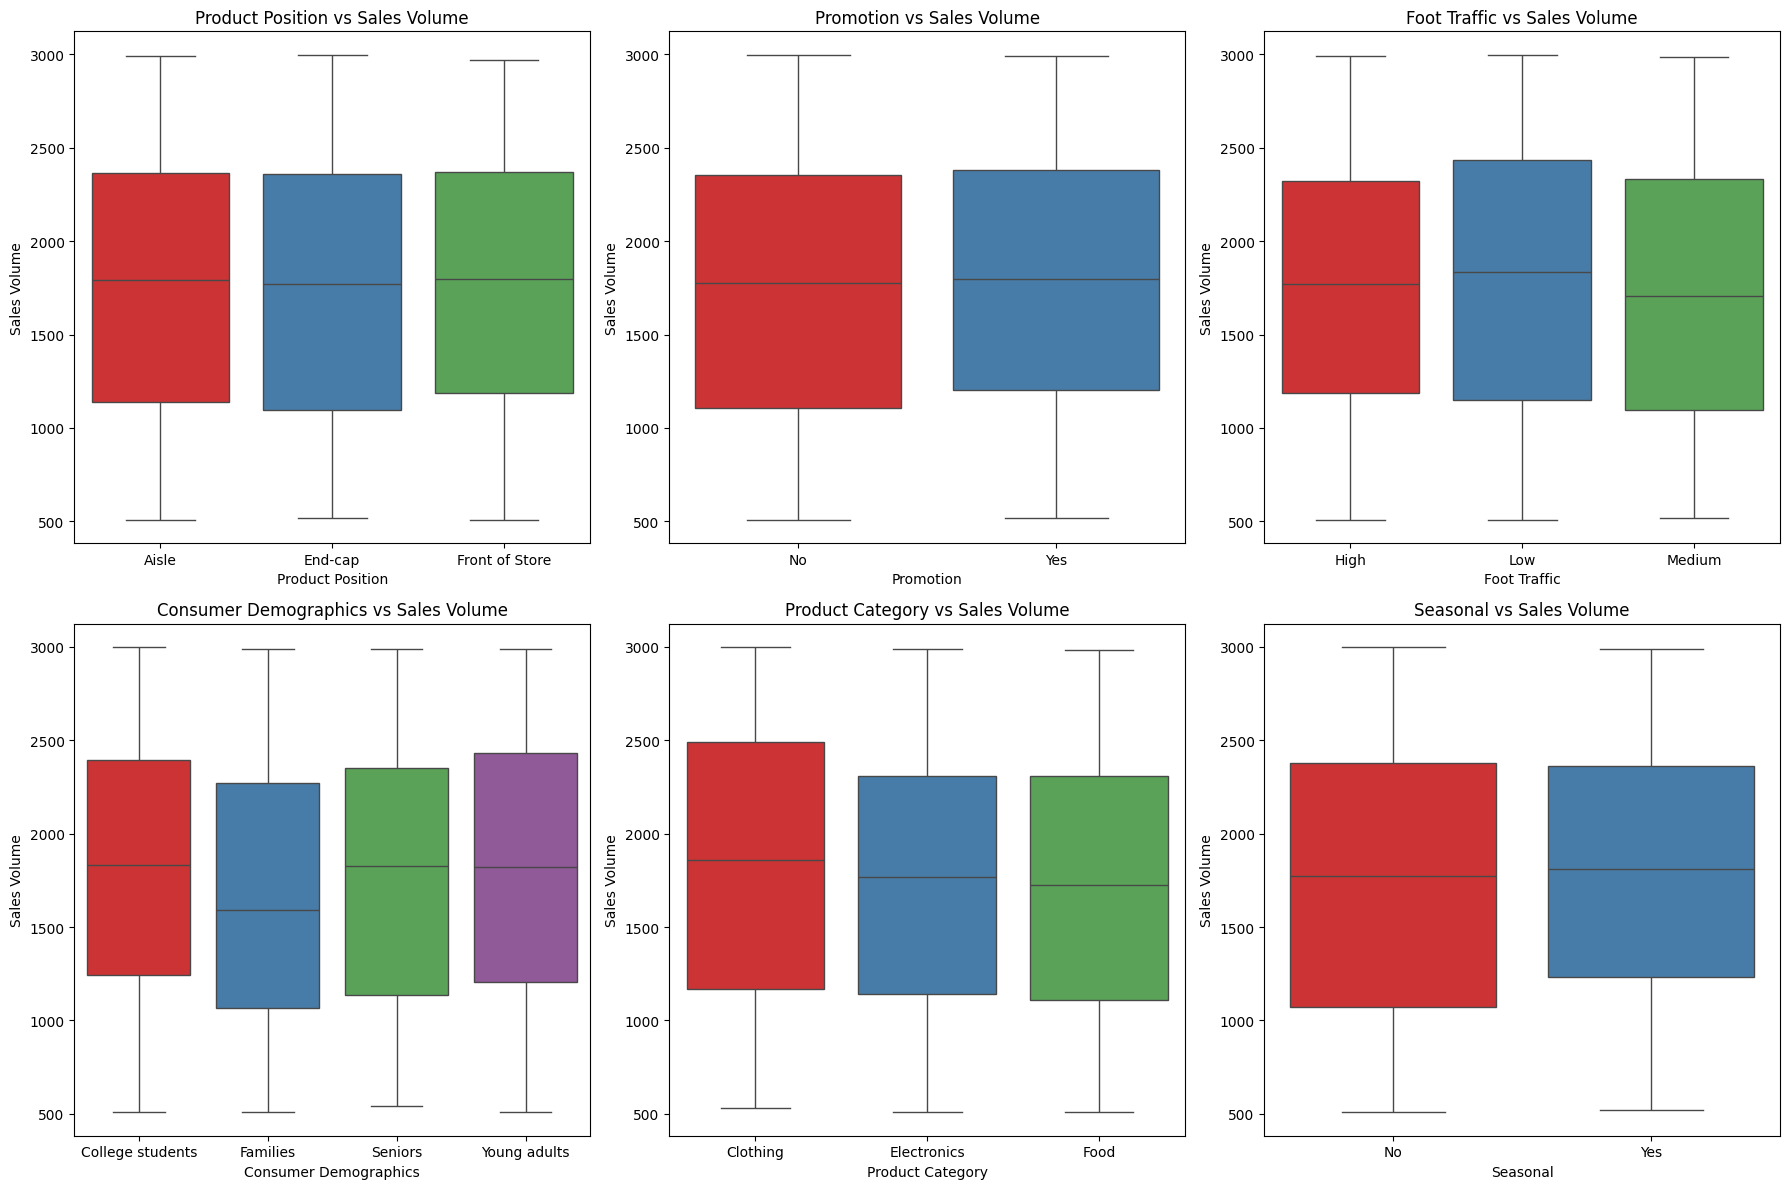

In [5]:
plt.figure(figsize=(18,12))
for i, col in enumerate(df.select_dtypes(include=['category']).columns):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=df[col], y=df['Sales Volume'], hue=df[col], palette='Set1', dodge=False)
    plt.title(f'{col} vs Sales Volume')
plt.tight_layout()
plt.show()

I have chosen to take a closer look at position and sales volume with a bar plot

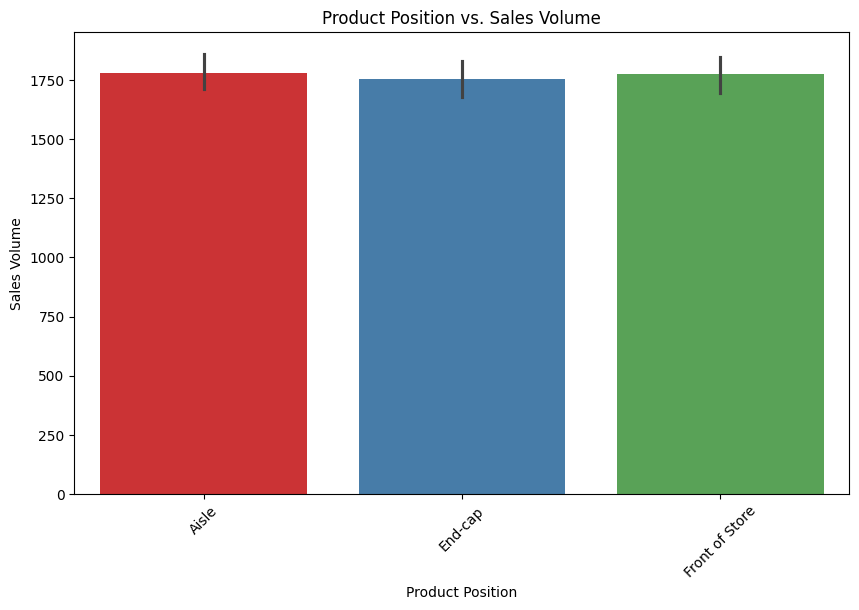

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Product Position', y='Sales Volume', hue='Product Position', data=df, palette='Set1', dodge=False)
plt.xticks(rotation=45)
plt.title('Product Position vs. Sales Volume')
plt.show()

Here I am taking a closer look at foot traffic and sales volume with a bar plot. I have chosen Product Positioning and Foot Traffic as though interest me the most when looking at product positioning - though other factors are important.

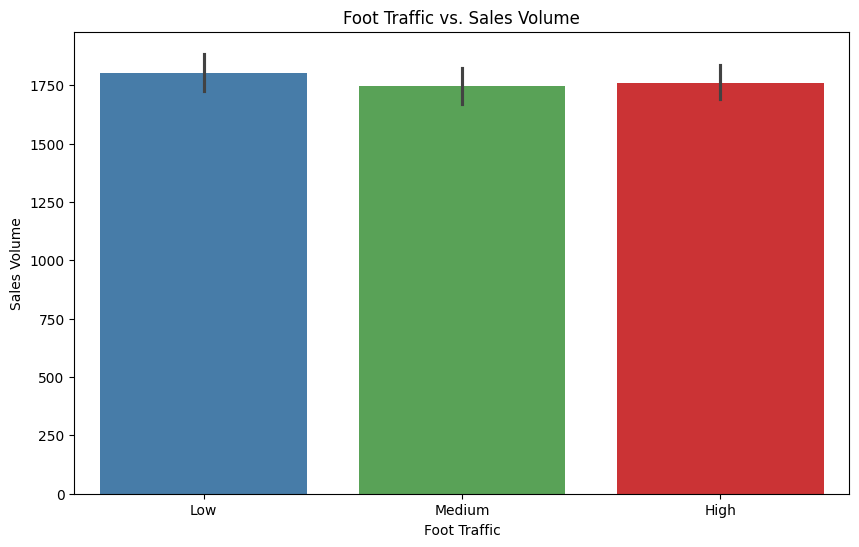

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Foot Traffic', y='Sales Volume', data=df, hue='Foot Traffic', palette='Set1', order=['Low', 'Medium', 'High'], dodge=False)
plt.title('Foot Traffic vs. Sales Volume')
plt.show()

### Predictive Modeling

Here I am preparing the data by taking "Sales volume" out of the X so the model doesn't train with the outcome variable in the data

In [8]:
x = df.drop('Sales Volume', axis=1)
y = df['Sales Volume']

Below I am applying one-hot coding to the categorical columns only. 

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False 
)

Below is an ML pipeline to preprocess the data with 1. one hot coding, 2. scaling it, 3. fitting the linear regression. 

In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Product Position',
                                                   'Promotion', 'Foot Traffic',
                                                   'Consumer Demographics',
                                                   'Product Category',
                                                   'Seasonal'])])),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Here the pipeline created above is making predictions and evaluating the performance by calculating the MSE and R2, checking its accuracy and GOF

In [11]:
y_pred = pipeline.predict(x)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 508094.48575198796
R-squared: 0.014486577124589006


Here I am running an ANOVA on product position and sales volume, and retreiving the F-statistic and P-value

In [12]:
product_position_groups = df.groupby('Product Position')['Sales Volume']
anova_results = f_oneway(*(group for name, group in product_position_groups))
print("ANOVA Test Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

ANOVA Test Results:
F-statistic: 0.1244626416427525
p-value: 0.8829849641492286


/var/folders/yj/y007xzpn71b3cmx87nr5lc340000gn/T/ipykernel_76954/1198099215.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_position_groups = df.groupby('Product Position')['Sales Volume']


Here I am using a linear regression to obtain the ML feature importances of each coefficient to determine their "weight"/importance in the prediction making in the model

In [13]:
coefs = pipeline.named_steps['regressor'].coef_

feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names = list(feature_names) + list(x.select_dtypes(include=['number']).columns)

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coefs_df = coefs_df.sort_values(by='Coefficient', ascending=False)
print(coefs_df)

                               Feature  Coefficient
13                  Competitor's Price   182.974564
3                     Foot Traffic_Low    19.981901
10                        Seasonal_Yes    19.284457
7   Consumer Demographics_Young adults    13.577213
2                        Promotion_Yes    11.185301
6        Consumer Demographics_Seniors     1.007491
11                          Product ID    -2.005645
1      Product Position_Front of Store    -3.498714
4                  Foot Traffic_Medium    -6.417079
0             Product Position_End-cap   -16.525946
8         Product Category_Electronics   -39.668449
5       Consumer Demographics_Families   -47.320221
9                Product Category_Food   -48.662061
12                               Price  -148.809835


Below I am obtaining the feature importances for the values in a Random Forest regression. 

In [14]:
categorical_cols = x.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  
    ('regressor', RandomForestRegressor())
])

pipeline.fit(x, y)

importances = pipeline.named_steps['regressor'].feature_importances_

feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names = list(feature_names) + list(x.select_dtypes(include=['number']).columns)

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                               Feature  Importance
11                          Product ID    0.274273
12                               Price    0.223823
13                  Competitor's Price    0.217627
10                        Seasonal_Yes    0.030878
2                        Promotion_Yes    0.028553
8         Product Category_Electronics    0.028483
3                     Foot Traffic_Low    0.027441
1      Product Position_Front of Store    0.027062
9                Product Category_Food    0.026617
4                  Foot Traffic_Medium    0.024763
0             Product Position_End-cap    0.023908
5       Consumer Demographics_Families    0.023592
6        Consumer Demographics_Seniors    0.022553
7   Consumer Demographics_Young adults    0.020428


Below I'm performing ANOVA tests for all categorical features compared to sales volume and having it print the F-Statistic and P-Value

In [15]:
categorical_features = ['Product Position', 'Promotion', 'Foot Traffic', 'Consumer Demographics', 'Product Category', 'Seasonal']

for feature in categorical_features:
    groups = [df[df[feature] == cat]['Sales Volume'] for cat in df[feature].unique()]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA for {feature} - F-statistic: {f_stat}, p-value: {p_val}")

ANOVA for Product Position - F-statistic: 0.1244626416427525, p-value: 0.8829849641492286
ANOVA for Promotion - F-statistic: 0.1415888066976645, p-value: 0.7067865818972456
ANOVA for Foot Traffic - F-statistic: 0.5725532837342765, p-value: 0.5642686948572067
ANOVA for Consumer Demographics - F-statistic: 1.7518973712558734, p-value: 0.15474429582321914
ANOVA for Product Category - F-statistic: 1.9025818452274679, p-value: 0.14972419953694585
ANOVA for Seasonal - F-statistic: 0.759381791730529, p-value: 0.38373163573390723
